# Regression

In this tutorial, we will build a regression model for a two-color FRET dataset. The dataset has been manually labeled with a binary label per-frame indicating whether the frame should be included for next step analysis. To demonstrate the regression function of metasim, we will train a model to predict **how many** frames in a trace is labeled true.

In [5]:
import openfret
import metasim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

# Load data

Here, we use dataset from the paper: 

Widom, J. R. et al. Ligand Modulates Cross-Coupling between Riboswitch Folding and Transcriptional
Pausing. Mol. Cell 72, 541-552.e6 (2018). 

We have converted the dataset into a train set and a test set, both in the OpenFRET format. For details on OpenFRET data format, please visit this [link](https://github.com/simol-lab/OpenFRET)

In [6]:
train_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_framelevel_train.json'),
)
test_data = metasim.fret.data.TwoColorDataset(
    openfret.read_data('saved_dataset/openfret/cond_3_framelevel_test.json'),
)

To inspect the traces, the plot traces from each label class in the training dataset.

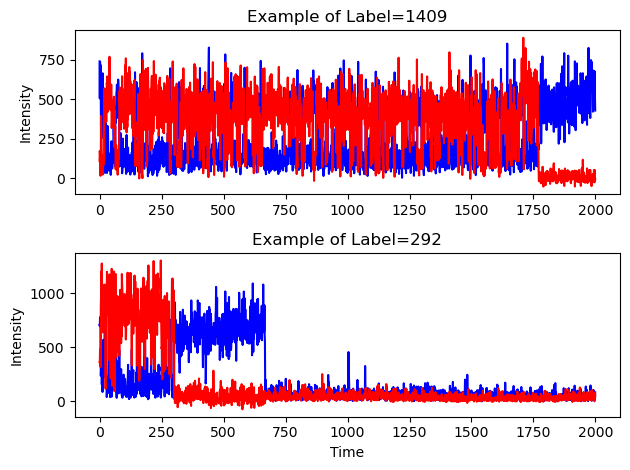

In [7]:
fig, axes = plt.subplots(2)
for trace in train_data.traces:
    if np.sum(trace.metadata['manual_label']) > 500:
        for channel in trace.channels:
            if channel.channel_type == 'donor':
                color = 'b'
            elif channel.channel_type == 'acceptor':
                color = 'r'
            axes[0].plot(channel.data, color=color)
            axes[0].set_ylabel('Intensity')
            axes[0].set_title(f'Example of Label={np.sum(trace.metadata["manual_label"])}')
        break
for trace in train_data.traces:
    if np.sum(trace.metadata['manual_label']) < 500:
        for channel in trace.channels:
            if channel.channel_type == 'donor':
                color = 'b'
            elif channel.channel_type == 'acceptor':
                color = 'r'
            axes[1].plot(channel.data, color=color)
            axes[1].set_ylabel('Intensity')
            axes[1].set_xlabel('Time')
            axes[1].set_title(f'Example of Label={np.sum(trace.metadata["manual_label"])}')
        break
plt.tight_layout()

# Regression Model

Here we use META-SiM's built-in function to train a regression model for this problem, based on the embeddings generated by META-SiM.

In [8]:
model = metasim.fret.Model()
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding = model(train_data)

  0%|          | 0/53 [00:00<?, ?it/s]

In [9]:
label = np.array([np.sum(trace.metadata['manual_label']) for trace in train_data.traces])

In [10]:
task_model = metasim.fret.tuning.train_regression(
    embedding,
    label,
)

Since META-SiM predicts the full probability distribution of the predicted label, at inference time, we can optimize for different eval metrics such as MAE and RMSE.

In [11]:
pred_mae = task_model.predict_regression(embedding, optimize_for='mae')
pred_rmse = task_model.predict_regression(embedding, optimize_for='rmse')

In [12]:
print('Training MAE for MAE prediction is', np.mean(np.abs(pred_mae - label)))
print('Training RMSE for RMSE prediction is', np.sqrt(np.sum(np.square(pred_rmse - label))))

Training MAE for MAE prediction is 79.98113207547169
Training RMSE for RMSE prediction is 770.6085041903227


# Evaluation on test data

We can use test data collected from different experimental trials to test the performance of the classification model. 

It's recommended to use data from different experiment trials for testing because in practice the model will be used on new experimental data.

In [13]:
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding_test = model(test_data)
label_test = np.array([trace.metadata['manual_label'] for trace in test_data.traces])

  0%|          | 0/313 [00:00<?, ?it/s]

In [14]:
label_test = np.array([np.sum(trace.metadata['manual_label']) for trace in test_data.traces])

In [15]:
pred_mae_test = task_model.predict_regression(embedding_test, optimize_for='mae')
pred_rmse_test = task_model.predict_regression(embedding_test, optimize_for='rmse')

In [16]:
print('Test MAE for MAE prediction is', np.mean(np.abs(pred_mae_test - label_test)))
print('Test RMSE for RMSE prediction is', np.sqrt(np.sum(np.square(pred_rmse_test - label_test))))

Test MAE for MAE prediction is 275.5495207667732
Test RMSE for RMSE prediction is 5906.435250308442


Finally, we can show a scatter plot between the ground truth and the prediction for the test dataset.

Text(0.5, 1.0, 'Scatter plot between predicted and ground truth labels using META-SiM regression.')

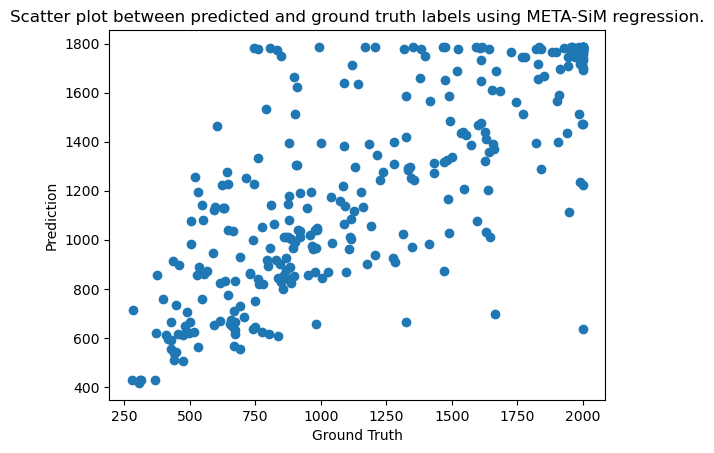

In [17]:
plt.scatter(label_test, pred_rmse_test)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Scatter plot between predicted and ground truth labels using META-SiM regression.')

# Save and load model

Now that we have a trained and validated the model, we will save it to re-use it in the future. Models can be easily saved and read with buit-in functions.

In [18]:
task_model.save_to_json('/tmp/saved_model.json')

In [19]:
loaded_model = metasim.fret.tools.tuning.ModelConfig.load_from_json(
    '/tmp/saved_model.json',
)